<a href="https://colab.research.google.com/github/Dheeraj-afk7/healthcare_sih/blob/main/SIH_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install and import necessary libraries
!pip install scikit-learn-extra
!pip install wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load the dataset
from google.colab import files
uploaded = files.upload()

# Read the CSV file
df = pd.read_csv('Diseases_Symptoms.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=2177959 sha256=21c287566e3b6c89de04e4d9c374dad6dd778dc9e19df9040979beaf7fd927f1
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


Saving Diseases_Symptoms.csv to Diseases_Symptoms.csv
Dataset shape: (400, 4)

First few rows:


,Code,Name,Symptoms,Treatments
0,1,Panic disorder,"Palpitations, Sweating, Trembling, Shortness o...","Antidepressant medications, Cognitive Behavior..."
1,2,Vocal cord polyp,"Hoarseness, Vocal Changes, Vocal Fatigue","Voice Rest, Speech Therapy, Surgical Removal"
2,3,Turner syndrome,"Short stature, Gonadal dysgenesis, Webbed neck...","Growth hormone therapy, Estrogen replacement t..."
3,4,Cryptorchidism,"Absence or undescended testicle(s), empty scro...",Observation and monitoring (in cases of mild o...
4,5,Ethylene glycol poisoning-1,"Nausea, vomiting, abdominal pain, General mala...","Supportive Measures, Gastric Decontamination, ..."


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Code        400 non-null    int64 
 1   Name        400 non-null    object
 2   Symptoms    400 non-null    object
 3   Treatments  399 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.6+ KB
None

Missing values:
Code          0
Name          0
Symptoms      0
Treatments    1
dtype: int64

Number of duplicates: 0

Disease counts:
Name
Sciatica                                 3
Complex Regional Pain Syndrome (CRPS)    2
Fibromyalgia                             2
Mucocele                                 2
Urinary Tract Infection (UTI)            2
Endometriosis                            2
Dermatitis due to Sun Exposure           2
Hypocalcemia                             1
Pharyngitis                              1
Thyroid Disease                          1
Name: count, dt

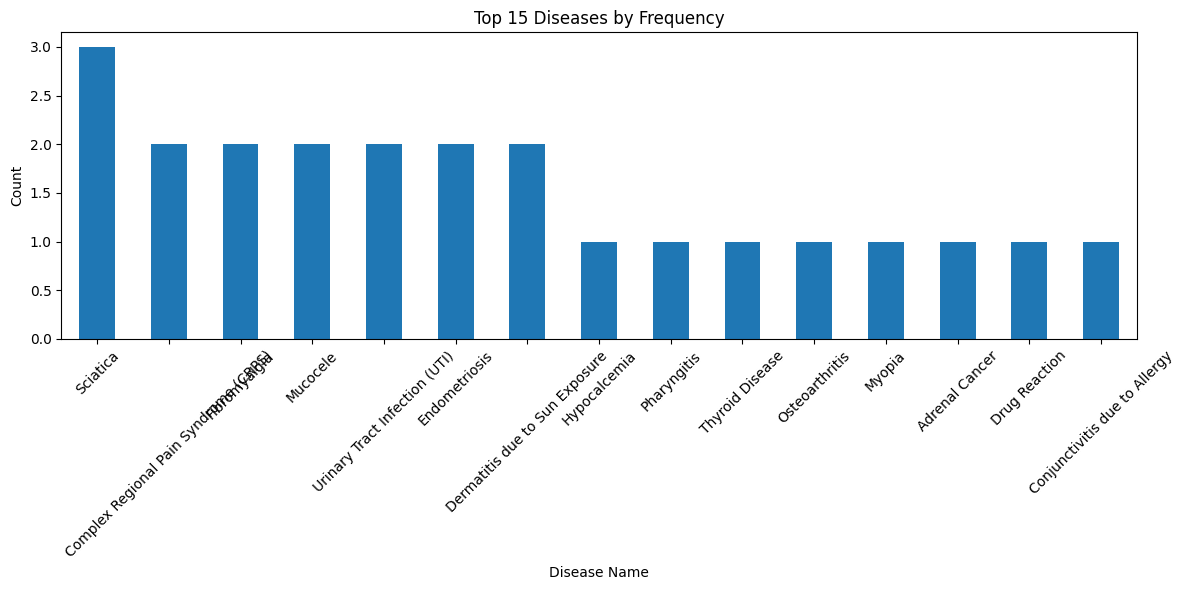

In [2]:
# Data Exploration and Preprocessing
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nNumber of duplicates: {df.duplicated().sum()}")

# Basic statistics
print("\nDisease counts:")
print(df['Name'].value_counts().head(10))

# Visualize the top diseases
plt.figure(figsize=(12, 6))
df['Name'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Diseases by Frequency')
plt.xlabel('Disease Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Preprocessing symptoms...
Columns in DataFrame: ['Code', 'Name', 'Symptoms', 'Treatments', 'Cleaned_Symptoms']
First few rows with cleaned symptoms:
                                            Symptoms  \
0  Palpitations, Sweating, Trembling, Shortness o...   
1           Hoarseness, Vocal Changes, Vocal Fatigue   
2  Short stature, Gonadal dysgenesis, Webbed neck...   
3  Absence or undescended testicle(s), empty scro...   
4  Nausea, vomiting, abdominal pain, General mala...   

                                    Cleaned_Symptoms  
0  palpitation sweating trembling shortness breat...  
1              hoarseness vocal change vocal fatigue  
2  short stature gonadal dysgenesis webbed neck l...  
3  absence undescended testicle empty scrotum sma...  
4  nausea vomiting abdominal pain general malaise...  


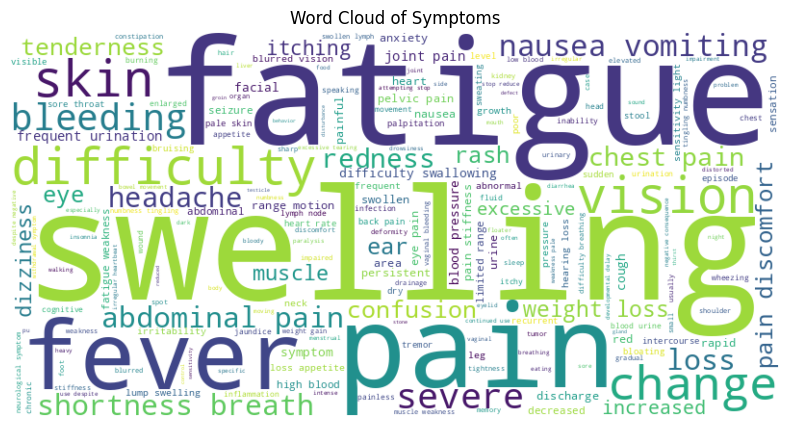

In [4]:
# Text Preprocessing for Symptoms
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    # Convert to lowercase
    text = str(text).lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# Apply preprocessing to symptoms
print("Preprocessing symptoms...")
df['Cleaned_Symptoms'] = df['Symptoms'].apply(preprocess_text)

# Check if the column was created successfully
print("Columns in DataFrame:", df.columns.tolist())
print("First few rows with cleaned symptoms:")
print(df[['Symptoms', 'Cleaned_Symptoms']].head())

# Step 5: Create a word cloud of symptoms
all_symptoms = ' '.join(df['Cleaned_Symptoms'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_symptoms)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Symptoms')
plt.show()

In [6]:
# Prepare data for machine learning
# First, let's check the distribution of diseases
disease_counts = df['Name'].value_counts()
print("Disease distribution:")
print(disease_counts)

# Identify diseases with only one example
single_instance_diseases = disease_counts[disease_counts == 1].index.tolist()
print(f"\nNumber of diseases with only one example: {len(single_instance_diseases)}")
print("Diseases with only one example:", single_instance_diseases)

# Option 1: Remove diseases with only one example (if there aren't too many)
if len(single_instance_diseases) > 0 and len(single_instance_diseases) < len(df) * 0.1:
    # If less than 10% of data, remove these rare diseases
    df_filtered = df[~df['Name'].isin(single_instance_diseases)]
    print(f"Original dataset size: {len(df)}")
    print(f"Filtered dataset size: {len(df_filtered)}")

    # Use the filtered dataset
    df_to_use = df_filtered
else:
    # If too many rare diseases, keep them but don't stratify
    df_to_use = df
    print("Keeping all diseases but won't stratify the split")

# Encode disease names
label_encoder = LabelEncoder()
df_to_use['Disease_Encoded'] = label_encoder.fit_transform(df_to_use['Name'])

# Create TF-IDF features from symptoms
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = tfidf.fit_transform(df_to_use['Cleaned_Symptoms']).toarray()
y = df_to_use['Disease_Encoded']

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)

# Split the data - don't stratify if we have rare classes
if len(single_instance_diseases) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Split without stratification due to rare classes")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("Split with stratification")

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Number of unique diseases in training: {len(np.unique(y_train))}")
print(f"Number of unique diseases in test: {len(np.unique(y_test))}")

Disease distribution:
Name
Sciatica                                 3
Complex Regional Pain Syndrome (CRPS)    2
Fibromyalgia                             2
Mucocele                                 2
Urinary Tract Infection (UTI)            2
                                        ..
Tuberous Sclerosis                       1
Astigmatism                              1
Acute Otitis Media                       1
Actinic Keratosis                        1
Protein Deficiency                       1
Name: count, Length: 392, dtype: int64

Number of diseases with only one example: 385
Diseases with only one example: ['Hypocalcemia', 'Pharyngitis', 'Thyroid Disease', 'Osteoarthritis', 'Myopia', 'Adrenal Cancer', 'Drug Reaction', 'Conjunctivitis due to Allergy', 'Bell Palsy', 'Leukemia', 'Omphalitis', 'Abscess of Nose', 'Stenosis of the Tear Duct', 'Impulse Control Disorder', 'Anxiety', 'Labyrinthitis', 'Food Allergy', 'Narcolepsy', 'Scurvy', 'Chronic Rheumatic Fever', 'Chronic Knee Pain', 'Va

In [9]:
# Alternative approach - Symptom-based matching instead of ML classification

# Since we have a small dataset with many unique diseases, let's use a similarity-based approach
from sklearn.metrics.pairwise import cosine_similarity

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['Cleaned_Symptoms']).toarray()

def find_similar_diseases(symptoms, top_n=5):
    # Preprocess input symptoms
    cleaned_symptoms = preprocess_text(symptoms)

    # Transform using the same TF-IDF vectorizer
    symptoms_tfidf = tfidf.transform([cleaned_symptoms]).toarray()

    # Calculate cosine similarity with all diseases
    similarities = cosine_similarity(symptoms_tfidf, X)[0]

    # Get top N most similar diseases
    top_indices = similarities.argsort()[-top_n:][::-1]

    results = []
    for idx in top_indices:
        results.append({
            'disease': df['Name'].iloc[idx],
            'symptoms': df['Symptoms'].iloc[idx],
            'treatments': df['Treatments'].iloc[idx],
            'similarity': similarities[idx]
        })

    return results

# Test the similarity-based approach
test_symptoms = "headache, fever, fatigue"
similar_diseases = find_similar_diseases(test_symptoms)

print(f"Top diseases similar to symptoms: '{test_symptoms}'")
for i, disease in enumerate(similar_diseases, 1):
    print(f"{i}. {disease['disease']} (similarity: {disease['similarity']:.4f})")
    print(f"   Symptoms: {disease['symptoms']}")
    print(f"   Treatments: {disease['treatments']}")
    print()

Top diseases similar to symptoms: 'headache, fever, fatigue'
1. Cryptococcosis (similarity: 0.7926)
   Symptoms: Headache, fever, fatigue, cough, meningitis, pneumonia
   Treatments: Antifungal medication (e.g., Amphotericin B, Fluconazole), supportive care

2. Headache after lumbar puncture (similarity: 0.6600)
   Symptoms: throbbing headache
   Treatments: Epidural blood patch, Conservative measures

3. Intracranial Abscess (similarity: 0.6277)
   Symptoms: Headache, fever, neurological deficits
   Treatments: Antibiotics, surgical drainage or removal of the abscess, supportive care

4. Mumps (similarity: 0.5580)
   Symptoms: Swollen salivary glands (usually parotid), fever, headache, fatigue
   Treatments: Supportive care, pain relievers, isolation, vaccination (MMR)

5. Cat Scratch Disease (similarity: 0.5331)
   Symptoms: Swollen lymph nodes, fever, fatigue, headache, rash
   Treatments: Antibiotics (azithromycin, doxycycline), pain management, supportive care



Disease category distribution:
Disease_Category
Other             215
Infection          59
Syndrome           40
Injury             16
Cancer             15
Poisoning          12
Eye Condition      11
Deficiency         11
Pain Condition      8
Endocrine           7
Cardiovascular      6
Name: count, dtype: int64
Feature matrix shape: (400, 200)
Target variable shape: (400,)
Training set: (320, 200), Test set: (80, 200)
Number of unique categories: 11
Training Logistic Regression...
Logistic Regression Accuracy: 0.5875
                precision    recall  f1-score   support

        Cancer       0.00      0.00      0.00         3
Cardiovascular       0.00      0.00      0.00         1
    Deficiency       0.00      0.00      0.00         2
     Endocrine       0.00      0.00      0.00         1
 Eye Condition       0.00      0.00      0.00         2
     Infection       1.00      0.25      0.40        12
        Injury       0.00      0.00      0.00         3
         Other       0.57

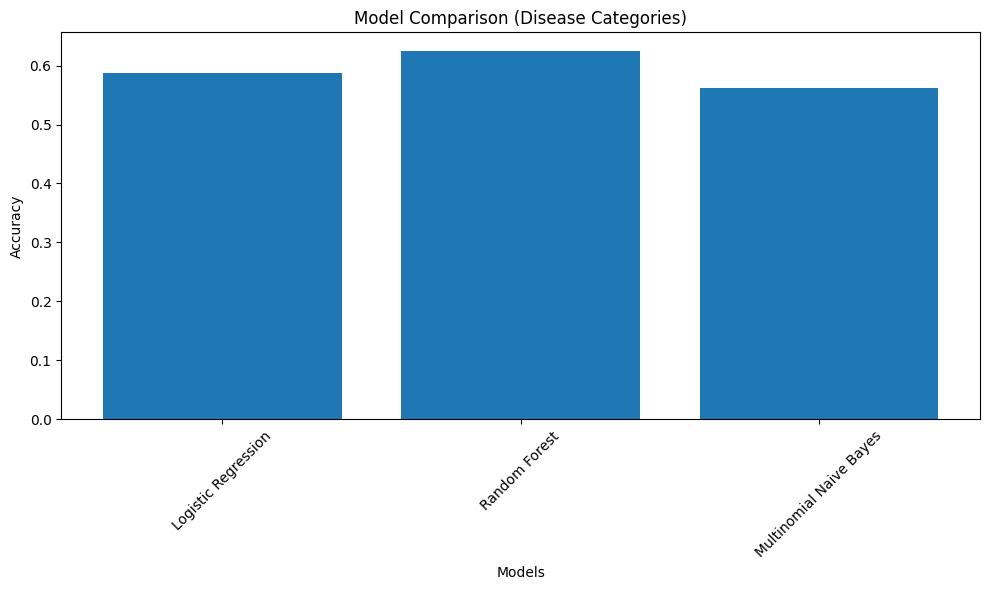

In [10]:
# Let's also try a simplified ML approach with fewer classes

# Group diseases into broader categories
def categorize_disease(disease_name):
    disease_name = disease_name.lower()

    if any(word in disease_name for word in ['cancer', 'carcinoma', 'tumor', 'lymphoma', 'leukemia']):
        return 'Cancer'
    elif any(word in disease_name for word in ['infection', 'itis', 'abscess', 'fever', 'pox']):
        return 'Infection'
    elif any(word in disease_name for word in ['syndrome', 'disorder']):
        return 'Syndrome'
    elif any(word in disease_name for word in ['deficiency', 'anemia']):
        return 'Deficiency'
    elif any(word in disease_name for word in ['poisoning', 'overdose', 'intoxication']):
        return 'Poisoning'
    elif any(word in disease_name for word in ['fracture', 'injury', 'dislocation', 'sprain']):
        return 'Injury'
    elif any(word in disease_name for word in ['glaucoma', 'cataract', 'vision', 'eye']):
        return 'Eye Condition'
    elif any(word in disease_name for word in ['heart', 'cardio', 'hypertension', 'blood pressure']):
        return 'Cardiovascular'
    elif any(word in disease_name for word in ['diabetes', 'thyroid', 'hormone']):
        return 'Endocrine'
    elif any(word in disease_name for word in ['arthritis', 'pain', 'ache']):
        return 'Pain Condition'
    else:
        return 'Other'

# Apply categorization
df['Disease_Category'] = df['Name'].apply(categorize_disease)

# Check category distribution
print("Disease category distribution:")
print(df['Disease_Category'].value_counts())

# Encode categories
label_encoder = LabelEncoder()
df['Category_Encoded'] = label_encoder.fit_transform(df['Disease_Category'])

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=200)
X = tfidf.fit_transform(df['Cleaned_Symptoms']).toarray()
y = df['Category_Encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Number of unique categories: {len(np.unique(y))}")

# Train and evaluate models on categories
category_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Multinomial Naive Bayes': MultinomialNB(),
}

category_results = {}
for name, model in category_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    category_results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

    print(classification_report(y_test, y_pred,
                               target_names=label_encoder.classes_,
                               zero_division=0))
    print("-" * 50)

# Compare model performance
plt.figure(figsize=(10, 6))
plt.bar(category_results.keys(), category_results.values())
plt.title('Model Comparison (Disease Categories)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Create a hybrid approach - first predict category, then find similar diseases within category

def predict_disease_hybrid(symptoms, top_n=3):
    # Preprocess input symptoms
    cleaned_symptoms = preprocess_text(symptoms)

    # First predict the disease category
    symptoms_tfidf = tfidf.transform([cleaned_symptoms]).toarray()
    category_pred = category_models['Random Forest'].predict(symptoms_tfidf)[0]
    category_name = label_encoder.inverse_transform([category_pred])[0]

    print(f"Predicted category: {category_name}")

    # Get diseases in this category
    category_diseases = df[df['Disease_Category'] == category_name]

    if len(category_diseases) == 0:
        return "No diseases found in this category"

    # Calculate similarity within this category
    category_indices = category_diseases.index
    category_features = X[category_indices]

    symptoms_features = tfidf.transform([cleaned_symptoms]).toarray()
    similarities = cosine_similarity(symptoms_features, category_features)[0]

    # Get top N most similar diseases in this category
    top_indices = similarities.argsort()[-top_n:][::-1]

    results = []
    for idx in top_indices:
        disease_idx = category_indices[idx]
        results.append({
            'disease': df['Name'].iloc[disease_idx],
            'symptoms': df['Symptoms'].iloc[disease_idx],
            'treatments': df['Treatments'].iloc[disease_idx],
            'similarity': similarities[idx],
            'category': category_name
        })

    return results

# Test the hybrid approach
test_symptoms = "headache, fever, fatigue"
results = predict_disease_hybrid(test_symptoms)

print(f"\nTop diseases for symptoms: '{test_symptoms}'")
for i, disease in enumerate(results, 1):
    print(f"{i}. {disease['disease']} (similarity: {disease['similarity']:.4f})")
    print(f"   Symptoms: {disease['symptoms']}")
    print(f"   Treatments: {disease['treatments']}")
    print()

Predicted category: Other

Top diseases for symptoms: 'headache, fever, fatigue'
1. Cryptococcosis (similarity: 0.7926)
   Symptoms: Headache, fever, fatigue, cough, meningitis, pneumonia
   Treatments: Antifungal medication (e.g., Amphotericin B, Fluconazole), supportive care

2. Mumps (similarity: 0.6584)
   Symptoms: Swollen salivary glands (usually parotid), fever, headache, fatigue
   Treatments: Supportive care, pain relievers, isolation, vaccination (MMR)

3. Cat Scratch Disease (similarity: 0.5331)
   Symptoms: Swollen lymph nodes, fever, fatigue, headache, rash
   Treatments: Antibiotics (azithromycin, doxycycline), pain management, supportive care



In [12]:
# Save the final model
import joblib

# Save the models and vectorizers
model_data = {
    'tfidf': tfidf,
    'category_model': category_models['Random Forest'],
    'label_encoder': label_encoder,
    'df': df,  # Save the original dataframe for similarity matching
    'preprocess_function': preprocess_text,
    'categorize_function': categorize_disease
}

joblib.dump(model_data, 'disease_prediction_model.pkl')

# Download the model file
files.download('disease_prediction_model.pkl')

print("Hybrid model saved successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hybrid model saved successfully!
